In [47]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerConfig, AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

In [48]:
import torch
# backbone = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
# backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# backbone.decode_head.classifier = torch.nn.Identity()

Using cache found in /home/wg25r/.cache/torch/hub/facebookresearch_dinov2_main


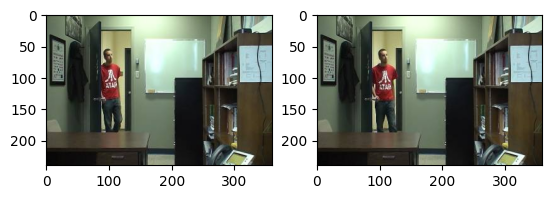

In [49]:
import os
import pylab
frames = os.listdir("/mnt/fastdata/dataset/baseline/office/input")
frames.sort()
pylab.subplot(1, 2, 1)
pylab.imshow(pylab.imread("/mnt/fastdata/dataset/baseline/office/input/"+frames[600]))
pylab.subplot(1, 2, 2)
pylab.imshow(pylab.imread("/mnt/fastdata/dataset/baseline/office/input/"+frames[605]))

In [50]:
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer

In [62]:
p_enc_2d = PositionalEncoding2D(384)
import numpy as np
def pos(x):
    x = x.reshape(1, 30, 30, 384).permute(0, 3, 1, 2)
    return (p_enc_2d(x) + x).permute(0, 2, 3, 1).reshape(900, 384)

torch.Size([900, 900]) torch.Size([30, 30, 2])


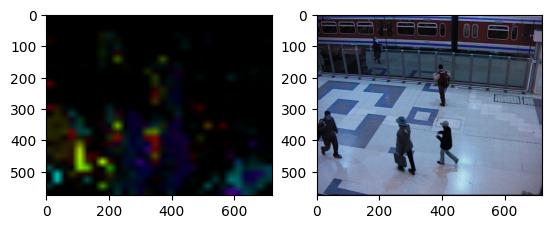

In [86]:
from PIL import Image
import cv2
import numpy as np 


def get_flow(image1, image2):
    global backbone
    backbone = backbone.eval()
    with torch.no_grad():
        image1 = image_processor(Image.open(image1), return_tensors="pt").pixel_values
        image2 = image_processor(Image.open(image2), return_tensors="pt").pixel_values
        image1 = torch.nn.functional.interpolate(image1, size=(420,420))
        image2 = torch.nn.functional.interpolate(image2, size=(420,420))
        image1_feature = backbone.get_intermediate_layers(image1)[0][0]
        image2_feature = backbone.get_intermediate_layers(image2)[0][0]
        image1_feature = pos(image1_feature)
        image2_feature = pos(image2_feature)
        w = 30 
        
        grid = torch.stack(torch.meshgrid(torch.arange(w), torch.arange(w)), dim=-1).float()
        matching = (image1_feature @ image2_feature.T)/np.sqrt(384) 
        print(matching.shape, grid.shape)
        flow = (((matching.softmax(-1) @ grid.flatten(0, 1)) - grid.flatten(0, 1)).reshape(w,w,2).detach()/w)
        flow_ = torch.stack([flow[:,:,0], torch.ones(size=flow[:,:,1].shape), flow[:,:,1]], dim=-1)
        hsv = np.zeros((w,w,3), dtype=np.uint8)
        hsv[..., 1] = 255
        mag, ang = cv2.cartToPolar(flow[..., 0].detach().numpy(), flow[..., 1].detach().numpy())
        hsv[..., 0] = ang*180/np.pi/2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return rgb

flow = get_flow("/mnt/fastdata/dataset/baseline/PETS2006/input/"+frames[100], 
                "/mnt/fastdata/dataset/baseline/PETS2006/input/"+frames[110])
current = cv2.imread("/mnt/fastdata/dataset/baseline/PETS2006/input/"+frames[100])
pylab.subplot(1, 2, 1)
pylab.imshow(cv2.resize(flow, (current.shape[1], current.shape[0]))) 
pylab.subplot(1, 2, 2)
pylab.imshow(current) 
# kemans? see class match?

In [60]:
from tqdm import tqdm
frames = sorted(os.listdir("/mnt/fastdata/dataset/baseline/PETS2006/input/"))[::4]
# write to video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1024, 512))


for frame_id in tqdm(range(0, len(frames)-1)):
    flow = get_flow("/mnt/fastdata/dataset/baseline/PETS2006/input/"+frames[frame_id], 
                    "/mnt/fastdata/dataset/baseline/PETS2006/input/"+frames[frame_id+1])
    # bicubic
    flow = cv2.resize(flow, (512, 512), interpolation=cv2.INTER_CUBIC)
    current_frame = cv2.imread("/mnt/fastdata/dataset/baseline/PETS2006/input/"+frames[frame_id])
    current_frame = cv2.resize(current_frame, (512, 512))
    
    # concate 
    concated = np.concatenate([current_frame, flow], axis=1)
    out.write(concated)
out.release() 
    

100%|██████████| 299/299 [01:01<00:00,  4.85it/s]


In [51]:
# pylab.subplot(1, 2, 1) 
# pylab.imshow((image1_feature.argmax(1)[0].detach())==12)
# pylab.subplot(1, 2, 2)
# pylab.imshow(image2_feature.argmax(1)[0].detach()==12)


In [52]:
image1_feature.shape

torch.Size([4096, 384])

In [54]:
# import numpy as np
# import cv2
# matching = (image1_feature @ image2_feature.T)/np.sqrt(768)
# flow = (matching.softmax(0)[:,:,None] * grid.flatten(0,1) - grid.flatten(0,1)).detach()/128
# flow = torch.stack([flow[:,:,0], torch.ones(size=flow[:,:,1].shape), flow[:,:,1]], dim=-1)
# pylab.imshow(cv2.cvtColor((flow.numpy() * 255).astype(np.uint8), cv2.COLOR_HSV2BGR)) 

In [113]:
import torchvision
torchvision.models.swin_t(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /home/wg25r/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 215MB/s]  


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [ ]:
from transformers import TimesformerForVideoClassification 
TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k600")

/home/wg25r/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense